# Simple Genetic Algorithm (SGA)

**George Lifchits** (100691350)

CP468: Artificial Intelligence | Wilfrid Laurier University

December 9, 2015

----

# Running this code

This project is implemented in a Jupyter (a.k.a. IPython) notebook, with code written in Python 3.

Jupyter allows the interspersal of simple formatted text and executable blocks of code with visible output. It also offers good integration with matplotlib, a Python plotting library, such that rendered graphs and plots are output directly in the notebook. 

More information on Jupyter can be found on their website: [https://jupyter.org/](https://jupyter.org/), and instructions on installing it can be found here: [http://jupyter.readthedocs.org/en/latest/install.html#new-to-python-and-jupyter](http://jupyter.readthedocs.org/en/latest/install.html#new-to-python-and-jupyter).

# SGA Implementation

We start off with some imports for plotting graphs.

In [1]:
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
matplotlib.rcParams['figure.figsize'] = (18.0, 8.0)

SGA has two important entities which have to be modelled in a code implementation: the *chromosome* and the *population*.

Here I implemented the chromosome as a Python string, where each character is either 0 or 1. Populations are a Python list of strings.

The following are helpers, including methods to initialize the population.

In [2]:
import random


def coin(prob):
    """
    Performs a biased coin toss.
    :param prob: [0 ≤ float ≤ 1]
    :returns: [bool] True with probability `prob` and otherwise False
    """
    # random.random() yields a float between 0 and 1
    return random.random() < prob


def random_string(length):
    """
    :param length: [int] length of random string
    :returns: [string] random string consisting of "0" and "1"
    """
    return ''.join('0' if coin(0.5) else '1' for _ in range(length))
    

def generate_random_population(number, length):
    """
    This function is used to generate the first population.
    This implementation ensure that chromosomes in the initial population
    are uniformly pseudo-random!
    
    :param number: [int] number of strings to return
    :param length: [int] length of the strings to return
    :returns: List[str] list of random binary strings
    """
    return [random_string(length) for _ in range(number)]

## Reproduction

One of the main three operators in SGA. It takes a population of chromosomes and generates a new population.

* Each chromosome in the population is assigned a weight, based off the chromosome's **fitness**
* The weights define how likely the member is going to be picked for the next population
  * This is called *biased roulette* selection

In [3]:
MIN = 0
MAX = 1


def reproduction(population, fitness_func, min_or_max=MAX):
    """
    Produces a new population from biased roulette reproduction of the given population.
    :param population: [List[str]]
    :param fitness_func: [function: number > 0]
    :param min_or_max: {MIN, MAX}
    :returns: [List[str]]
    """
    # First, we define the probability density (roulette weights) for each
    # member in our given population. 
    
    min_fitness = min(fitness_func(m) for m in population)
    
    def compute_weight(m):
        """
        Subroutine which computes the weight of the biased roulette, which 
        is agnostic of the fitness function. In particular, it will invert
        the fitness value if we are seeking a minimum. Member `m` has weight
        that is commensurate with its distance from the member with lowest
        fitness in the population.
        :param m: [str] member
        """
        fitness = fitness_func(m)
        
        if min_or_max == MAX:
            return fitness - min_fitness + 1
        
        elif min_or_max == MIN:
            return 1 / (fitness - min_fitness + 1)
    
    # Here we normalize the weights to be proportions of the total weighting
    weights = [(m, compute_weight(m)) for m in population]
    total_weights = sum(w for m, w in weights)
    pdf = [(m, w/total_weights) for m, w in weights]
    
    # Now we pick members for the new population.
    # We pick the same number of members as the provided population.
    new_population = []
    for i in range(len(population)):
        rand = random.random()
        cumul = 0
        for member, end_interval in pdf:
            cumul += end_interval
            if rand <= cumul:
                new_population.append(member)
                break # generate next member
    
    return new_population

## Crossover

* Take pairs from the population
* For each pair in the population, probability $P_c$ is the chance that any pair will be crossed over

What is cross over?
* Pick a random index, split the strings into "head" and "tail"
* Take the head of the first and tail of the second, and vice versa

**Example:**
* `aaabbb` and `xxxyyy`

Crossover at randomly chosen index 2:
* `aaa|yyy` and `xxx|bbb`

In [4]:
def crossover(string1, string2, index):
    """ Performs crossover on two strings at given index """
    head1, tail1 = string1[:index], string1[index:]
    head2, tail2 = string2[:index], string2[index:]
    return head1+tail2, head2+tail1


def population_crossover(population, crossover_probability):
    """
    Performs crossover on an entire population.
    :param population: List[str]
    :param crossover_probability: [0 ≤ float ≤ 1] probability that a given pair will be crossed over
    :returns: List[str] new population with possibly some members crossed over
    """
    pairs = []
    new_population = []
    while len(population) > 1:
        pairs.append((population.pop(), population.pop()))
    if len(population) == 1:
        new_population.append(population.pop())
        
    for s1, s2 in pairs:
        if not coin(crossover_probability): 
            # don't perform crossover, just add the original pair
            new_population += [s1, s2]
            continue
        idx = random.randint(1, len(s1)-1) # select crossover index
        new_s1, new_s2 = crossover(s1, s2, idx)
        new_population.append(new_s1)
        new_population.append(new_s2)
    return new_population

## Mutation

Creates perturbations in the population to find some chromosomes that are not available from the crossover operator.

* For every chromosome in the population,
  * for every bit in the chromosome, 
    * the bit will be flipped with a probability $P_m$

In [5]:
def mutation(string, probability):
    """
    :param string: the binary string to mutate
    :param probability: [0 ≤ float ≤ 1] the probability of any character being flipped
    :returns: [str] just the input string, possibly with some bits flipped
    """
    flipped = lambda x: '1' if x is '0' else '0'
    chars = (flipped(char) if coin(probability) else char for char in string)
    return ''.join(chars)


def mutate_population(population, prob):
    """
    :param population: [List[str]] population of binary strings
    :returns: [List[str]] just the input population, with some members possibly mutated
    """
    return [mutation(m, prob) for m in population]

### Main loop

The main loop of SGA is very small. It runs for any number of *eras* (provided as parameter).

In each era, we:

1. perform **reproduction** to create a new population from the old population
2. perform **crossover** on the population
3. perform **mutation** on the population

We save each population so that we can plot how the populations change after each era.

In [6]:
def run_genetic_algorithm(obj_fun, decoder, 
                          min_or_max=MAX, num_eras=100, population_size=20, chromosome_length=12, 
                          crossover_probability=0.4,mutation_probability=0.005):
    
    # define fitness function (decode string, then feed decoded to the objective_function)
    fitness = lambda coding: obj_fun(*decoder(coding))
    
    # initialize population
    population = generate_random_population(number=population_size, length=chromosome_length)
    # data collection
    populations = [population] # initialize with first population
    
    # SGA loop
    for i in range(num_eras):
        population = reproduction(population, fitness, min_or_max)
        population = population_crossover(population, crossover_probability)
        population = mutate_population(population, mutation_probability)
        populations.append(population) # data collection
    
    return populations

# Benchmarks

The benchmark objective functions are defined here. They are coding agnostic, so we focus on delivering an accurate OF implementation and worry about how to provide its parameters in the accompanying decoder function (see below).

In [7]:
def dejong_OF(*x):
    return sum(xi**2 for xi in x)


def rosenbrock_OF(*x):
    irange = range(len(x)-1)
    return sum(100 * (x[i+1] - x[i]**2)**2 + (1-x[i])**2 for i in irange)
    

def himmelblau_OF(x, y):
    return (x**2 + y - 11)**2 + (x + y**2 - 7)**2


def esf(*a):
    nov = len(a)
    terms = (a[i]*a[j] for i in range(nov) for j in range(i+1, nov))
    return abs(sum(terms))

## Decoders

As mentioned in the previous section ("Benchmarks") the objective functions operate with straightforward parameters. Here we implement methods that take a binary string and "decode" it. These decoder functions yield parameters which are fed directly into the objective function implementations above.

In [8]:
def split_string_into_chunks(string, n):
    """
    Helper function.
    :param string: [str]
    :param n: [int > 0] chunk size
    :returns: List[str] the entire string split into sequential chunks of the given size (plus remainder)
    
    example:
    
    >>> split_string_into_chunks('12345678', 3)
    ['123', '456', '78']
    
    >>> split_string_into_chunks('12345678', 4)
    ['1234', '5678']
    """
    return [string[i:i+n] for i in range(0, len(string), n)]


def dejong_decoder(coding):
    n = 4
    bits_list = split_string_into_chunks(coding, n)
    # take first bit as the sign, and the remaining bits as integers
    signs_nums = [(-1 if bits[0] == '0' else 1, int(bits[1:], 2)) for bits in bits_list]
    # use modulo to ensure that the numbers fall within the require interval: -5.12 ≤ x ≤ 5.12
    xlist = [sign * (num % 5.12) for sign, num in signs_nums]
    return xlist


def rosenbrock_decoder(coding):
    n = 3
    bits_list = split_string_into_chunks(coding, n)
    # take first bit as the sign, and the remaining bits as integers
    signs_nums = [(-1 if bits[0] == '0' else 1, int(bits[1:], 2)) for bits in bits_list]
    # use modulo to ensure that the numbers fall within the require interval: -2.048 ≤ x ≤ 2.048
    x = [sign * (num % 2.048) for sign, num in signs_nums]
    return x


def num_in_interval(lo, hi, mult, steps):
    """
    Helper function that takes simple parameters to yield a floating-point number in a given interval.
    
    ex. mult = 6, steps = 10
    
     |---+---+---+---+---+---|---+---+---+---|
    lo                      mult             hi
    
    if low = -10 and hi = 10, then the result will be 
      = -10 + 6*(20/10) 
      = -10 + 12 
      = 2

    :param lo: [number] low bound of interval
    :param hi: [number] high bound of interval
    :param mult: [number ≤ divisor] 
    :param steps: [int] the number of steps in the interval
    :returns: [float] a number between `lo` and `hi`, `mult/steps`% of the distance from `lo`
    """
    step_size = (hi - lo)/steps
    return lo + mult*step_size


def himmelblau_decoder(coding):
    mid = int(len(coding)/2)
    # split string into x param and y param
    binx, biny = coding[:mid], coding[mid:]
    # use binary x and y as interval multiplier
    xmult, ymult = int(binx, 2), int(biny, 2)
    # the divisor is the highest possible value x or y could be
    # which is 2**{length of binary string encoding x or y}
    x = num_in_interval(-4, 4, xmult, 2**len(binx))
    y = num_in_interval(-4, 4, ymult, 2**len(biny))
    return x, y


def esf_decoder(coding):
    return [-1 if char == '0' else 1 for char in coding]

## Tools for plotting

In [9]:
def plot_ga(obj_fun, decoder, ax=None, ga_opts=None, min_or_max=MIN, title="Genetic Algorithm Evolution"):
    if ga_opts is None:
        ga_opts = {}
        
    ga_opts['min_or_max'] = min_or_max
    # run SGA
    populations = run_genetic_algorithm(obj_fun, decoder, **ga_opts.copy())
    
    # define fitness func
    fitness = lambda c: obj_fun(*decoder(c))
    
    # Find the "global optimum" of all the chromosomes we looked at.
    # A better term for this chromosome is "best individual".
    all_chromosomes = {c for pop in populations for c in pop}
    optimizer = min if min_or_max == MIN else max
    global_optimum = optimizer(all_chromosomes, key=fitness)
    fittest_fitness = fitness(global_optimum)
    
    # Print the optimum to the console
    print("Global optimum:", global_optimum)
    print("Fitness:", fittest_fitness)
    print("Decoded:", decoder(global_optimum))
    
    # Start plotting
    # Define the data ranges
    x_axis = range(len(populations))
    fitnesses = [[fitness(m) for m in population] for population in populations]
    mins = [min(f) for f in fitnesses]
    maxs = [max(f) for f in fitnesses]
    avgs = [sum(f)/len(f) for f in fitnesses]
    optima = [(it, fittest_fitness) for it, pop in enumerate(populations) if fittest_fitness in map(fitness, pop)]
    x_optima, y_optima = zip(*optima) # unzip pairs into two sequences
    
    if ax is None: # if no plotting axes are provided
        # define a set of axes
        fig, ax = plt.subplots(1)
    
    # do the plotting
    line_mins, line_maxs, line_avgs = ax.plot(x_axis, mins, 'r--', maxs, 'b--', avgs, 'g-')
    scatter_ceil = ax.scatter(x_optima, y_optima, c='purple')
    
    # set parameters for the axes
    ax.set_xlim(0, len(populations))
    ax.set_ylim(0, int(max(maxs) * 1.20))
    ax.set_title(title)
    ax.set_xlabel("era")
    ax.set_ylabel("fitness")
    
    return ax

In [10]:
def plot_ga_minmax(objfun, decoder, min_ga_opts=None, max_ga_opts=None, title="Genetic Algorithm"):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    for ax, minimax, opts in [(ax1, MIN, min_ga_opts), (ax2, MAX, max_ga_opts)]:
        opts = opts or {} # if none, then use empty dict of options
        minimax_title = "minimization" if minimax == MIN else "maximization"
        print('\n', minimax_title, '\n', '='*len(minimax_title), '\n')
        plot_ga(
            objfun, decoder,
            ax=ax, min_or_max=minimax, 
            ga_opts=opts,
            title="{} ({})".format(title, minimax_title)
        )


def plot_esf_minmax(nov, min_ga_opts=None, max_ga_opts=None):
    # initialize option dicts as new dictionaries
    min_opts = {}
    max_opts = {}
    # update with parameter option dicts (if provided)
    min_opts.update(min_ga_opts or {})
    max_opts.update(max_ga_opts or {})
    # update with mandatory chromosome length = NOV
    min_opts['chromosome_length'] = nov
    max_opts['chromosome_length'] = nov
    # plot!
    plot_ga_minmax(esf, esf_decoder, title="ESF ({} vars)".format(nov), 
                   min_ga_opts=min_opts.copy(), max_ga_opts=max_opts.copy()
    )

## DeJong's Function

Optimal where all values $x_i = 0$.

This converges pretty quickly so I only use 50 eras of evolution.

Global optimum: 00001000100010001000
Fitness: 0.0
Decoded: [-0.0, 0.0, 0.0, 0.0, 0.0]


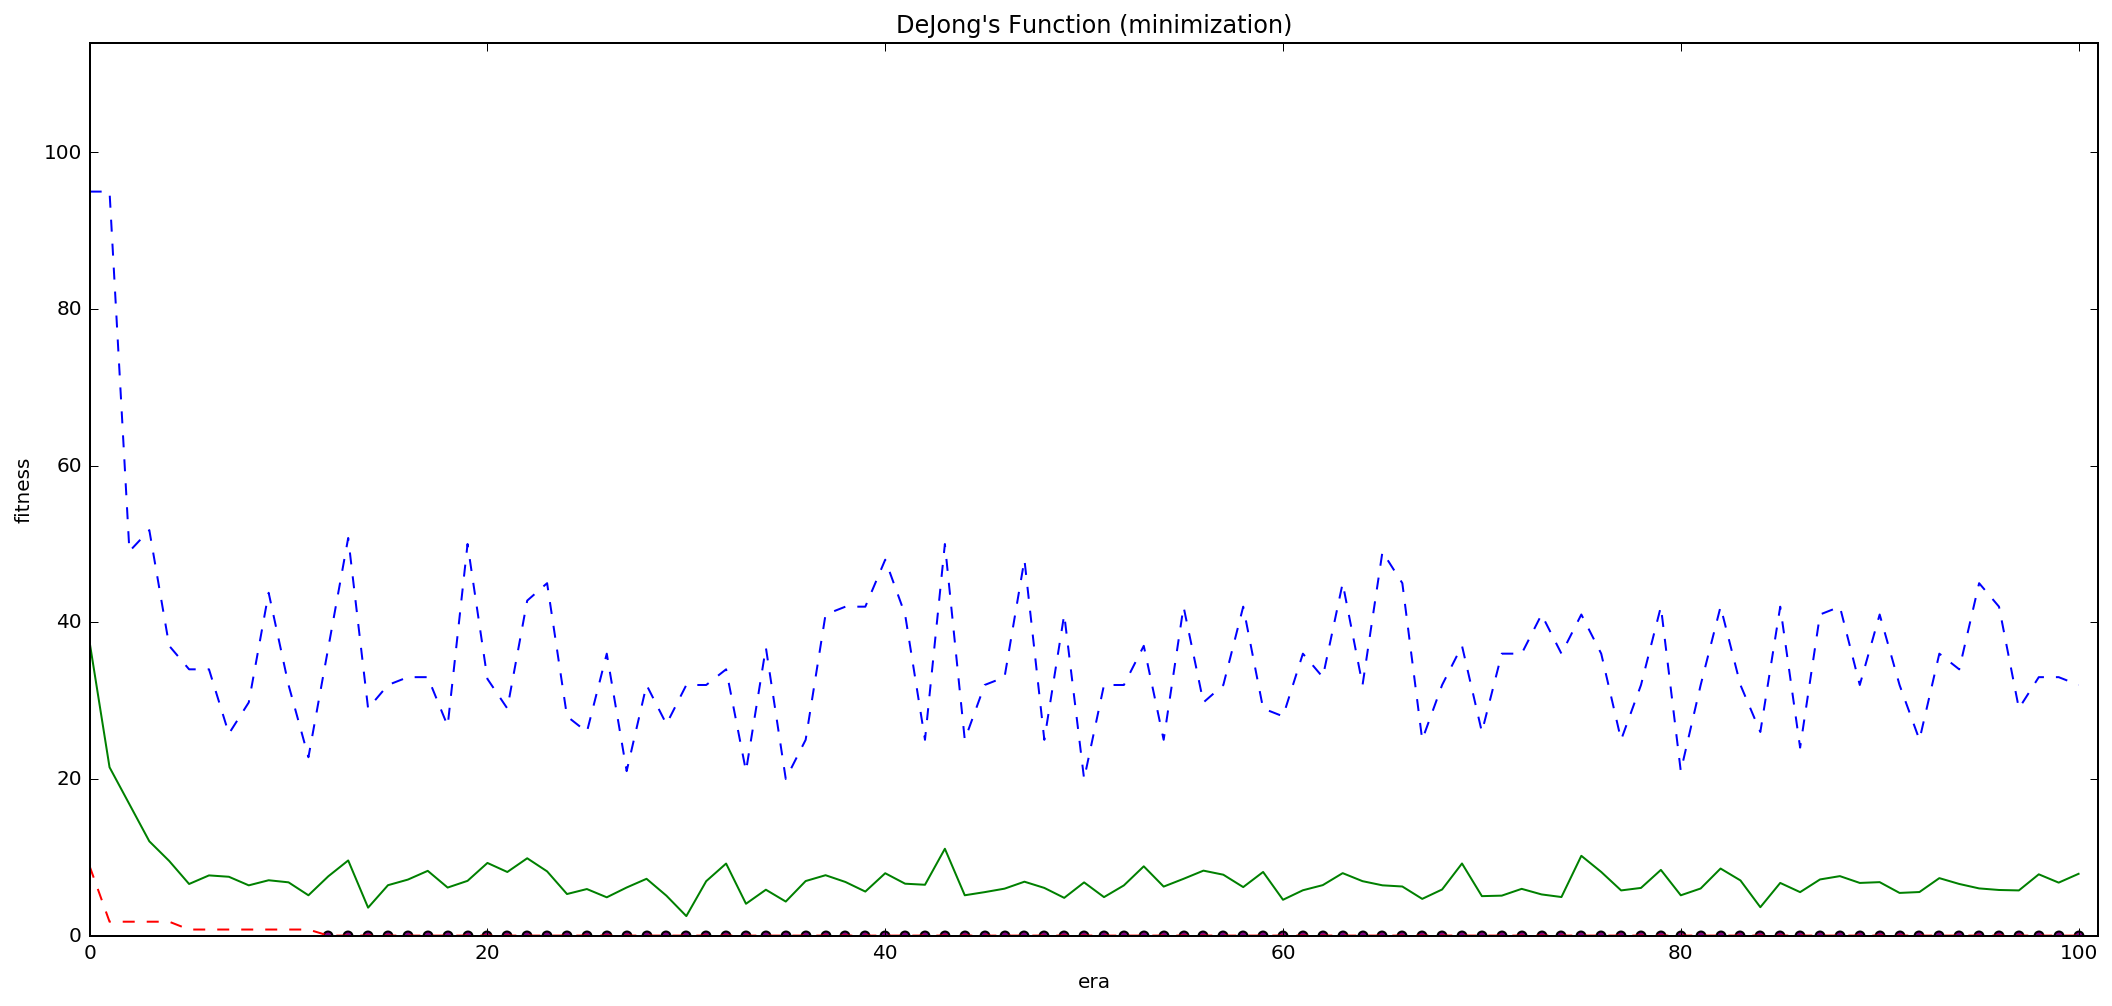

In [11]:
decoder = dejong_decoder
obj_fun = dejong_OF

ga_options = dict(
    num_eras=100, population_size=40, chromosome_length=20, 
    crossover_probability=0.3, mutation_probability=0.05  
)

plot_ga(obj_fun, decoder, min_or_max=MIN, ga_opts=ga_options, title="DeJong's Function (minimization)")

## Rosenbrock

Optimal where all values $x_i = 1$.

This does better when more mutation is allowed and there are a few more eras.

Global optimum: 10000000010010010000
Fitness: 6.0
Decoded: [0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0]


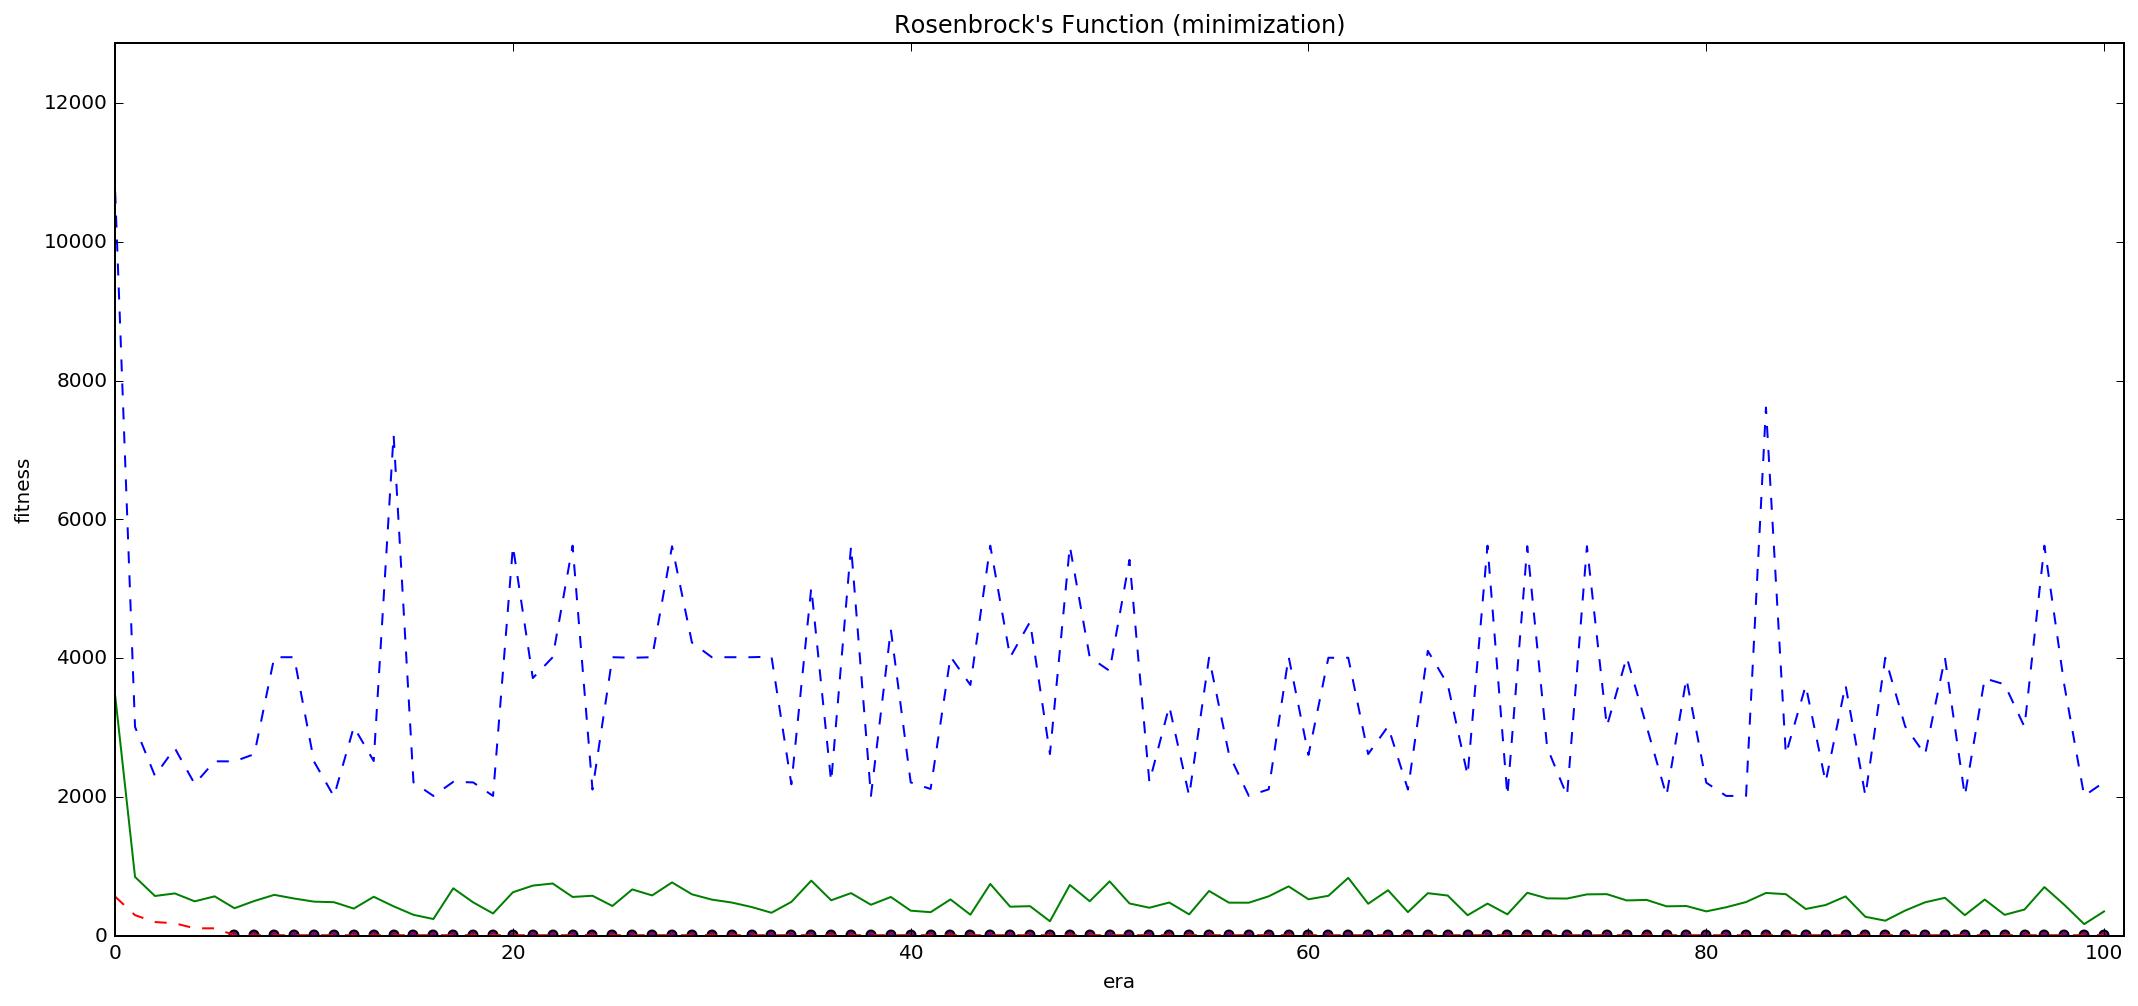

In [12]:
decoder = rosenbrock_decoder
obj_fun = rosenbrock_OF

ga_options = dict(
    num_eras=100, population_size=40, chromosome_length=20, 
    crossover_probability=0.35, mutation_probability=0.04
)

plot_ga(obj_fun, decoder, min_or_max=MIN, ga_opts=ga_options, title="Rosenbrock's Function (minimization)")

## Himmelblau


It has one local maximum at $x = -0.270845$ and $y = -0.923039$ where $f(x,y) = 181.617$, and four identical local minima:

* $f(3.0, 2.0) = 0.0$,
* $f(-2.805118, 3.131312) = 0.0$,
* $f(-3.779310, -3.283186) = 0.0$,
* $f(3.584428, -1.848126) = 0.0$

We work with a larger chromosome length to get higher fidelity real numbers.

Global optimum: 0010010111010111100000010010101111100101000010011100000010101011
Fitness: 0.03220647352857975
Decoded: (-2.8174432907253504, 3.1574405040591955)


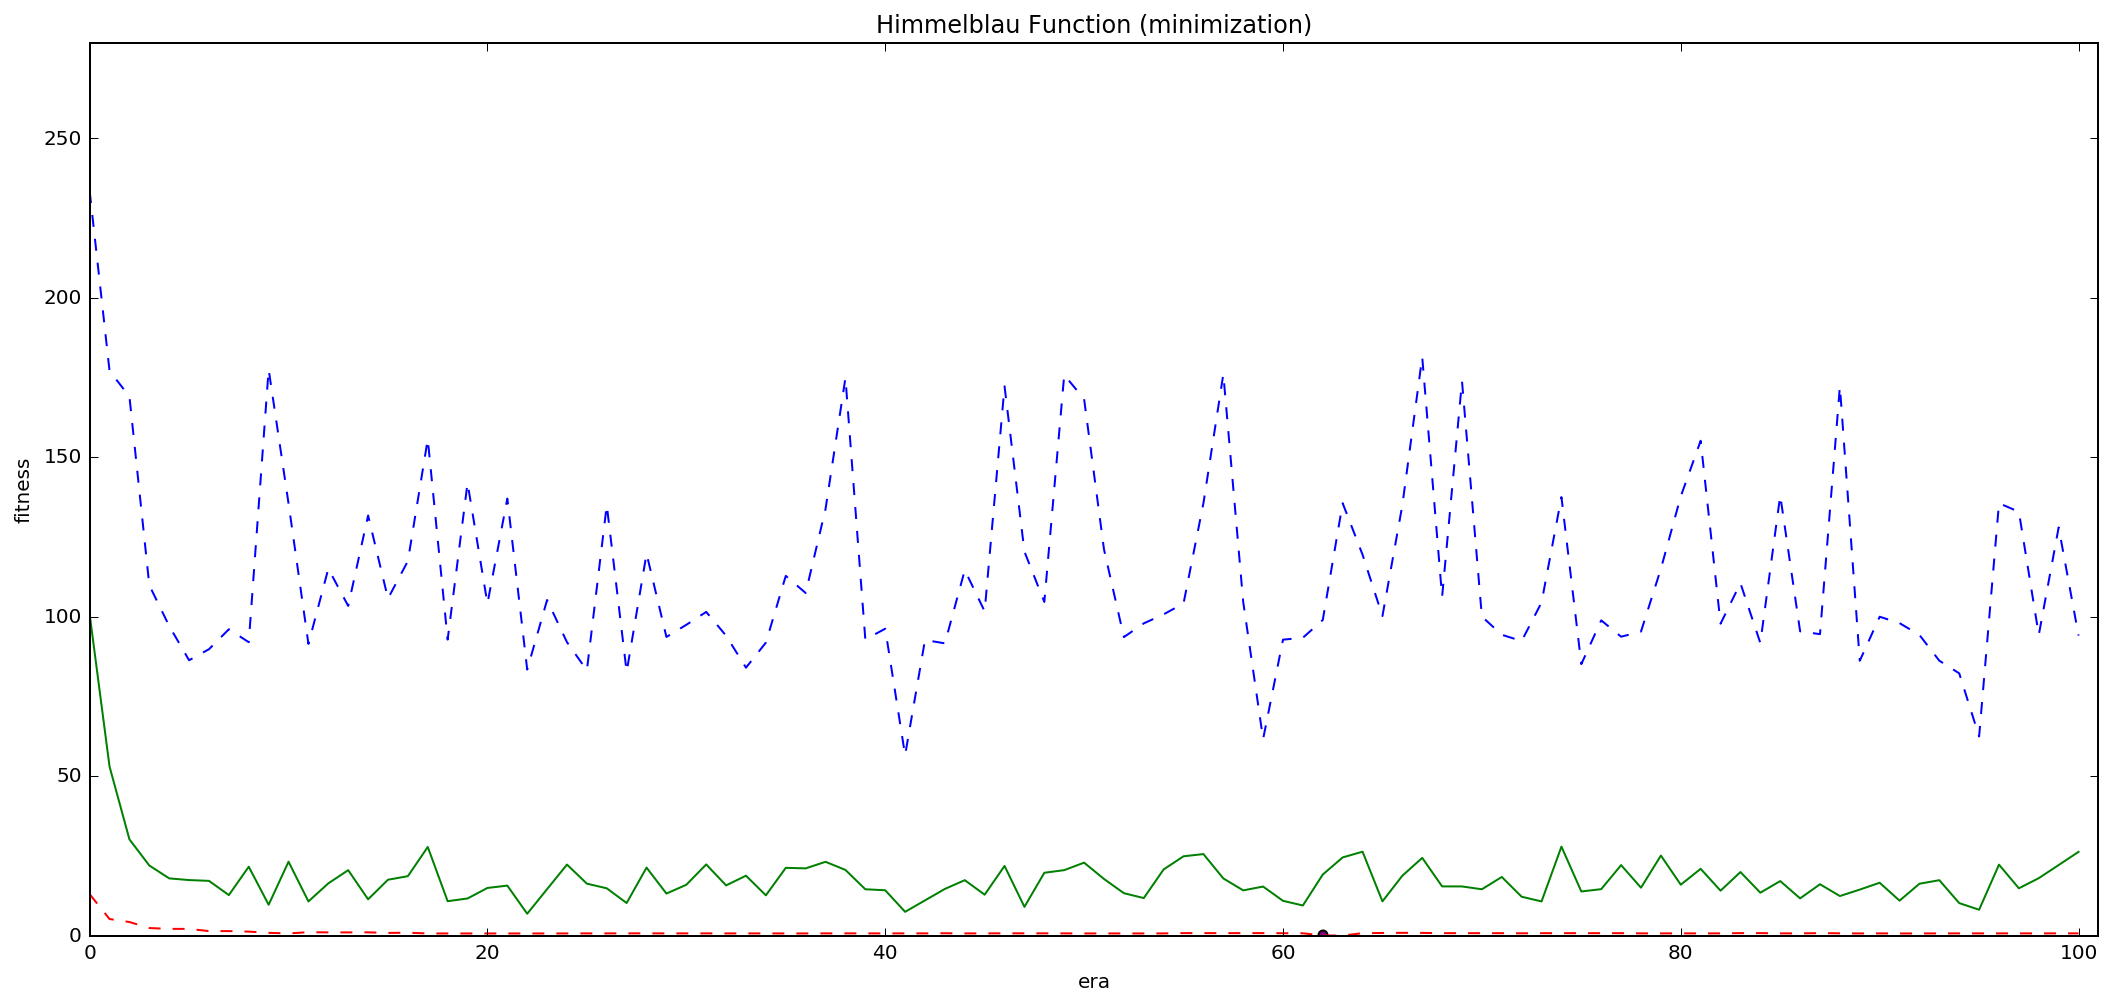

In [13]:
decoder = himmelblau_decoder
obj_fun = himmelblau_OF

fitness = lambda coding: obj_fun(*decoder(coding))

ga_opts = dict(
    num_eras=100, population_size=40, chromosome_length=64, 
    crossover_probability=0.35, mutation_probability=0.04
)

plot_ga(obj_fun, decoder, min_or_max=MIN, ga_opts=ga_opts, title="Himmelblau Function (minimization)")

# ESF benchmarks

Here we test the SGA performance on the elementary symmetric function.

### Simple brute force checker for minima and maxima

This small routine generates all binary strings of length `nov` and computes the fitness for all of those strings.

This is a simple way to find the global optima for the ESF benchmarks, but it is slow for more than 15 variables or so since there are $2^{\text{nov}}$ binary strings length `nov`.

In [14]:
def solve_esf(nov, fitness):
    all_binstrings = ["{:0{width}b}".format(i, width=nov) for i in range(2**nov)]
    the_min = min(all_binstrings, key=fitness)
    the_max = max(all_binstrings, key=fitness)
    return (the_min, the_max)


def solve_and_print(nov):
    fitness = lambda binstring: esf(*esf_decoder(binstring))
    the_min, the_max = solve_esf(nov, fitness)
    print('nov{}  =>  min fitness = {:<4}  max fitness = {:<4}'.format(nov, fitness(the_min), fitness(the_max)))

## ESF benchmarks in SGA

### NOV = 12

In [15]:
solve_and_print(12)

nov12  =>  min fitness = 2     max fitness = 66  


** NOV = 12, MIN = 2, MAX = 66 **


 minimization 

Global optimum: 001011000100
Fitness: 2
Decoded: [-1, -1, 1, -1, 1, 1, -1, -1, -1, 1, -1, -1]

 maximization 

Global optimum: 000000000000
Fitness: 66
Decoded: [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]


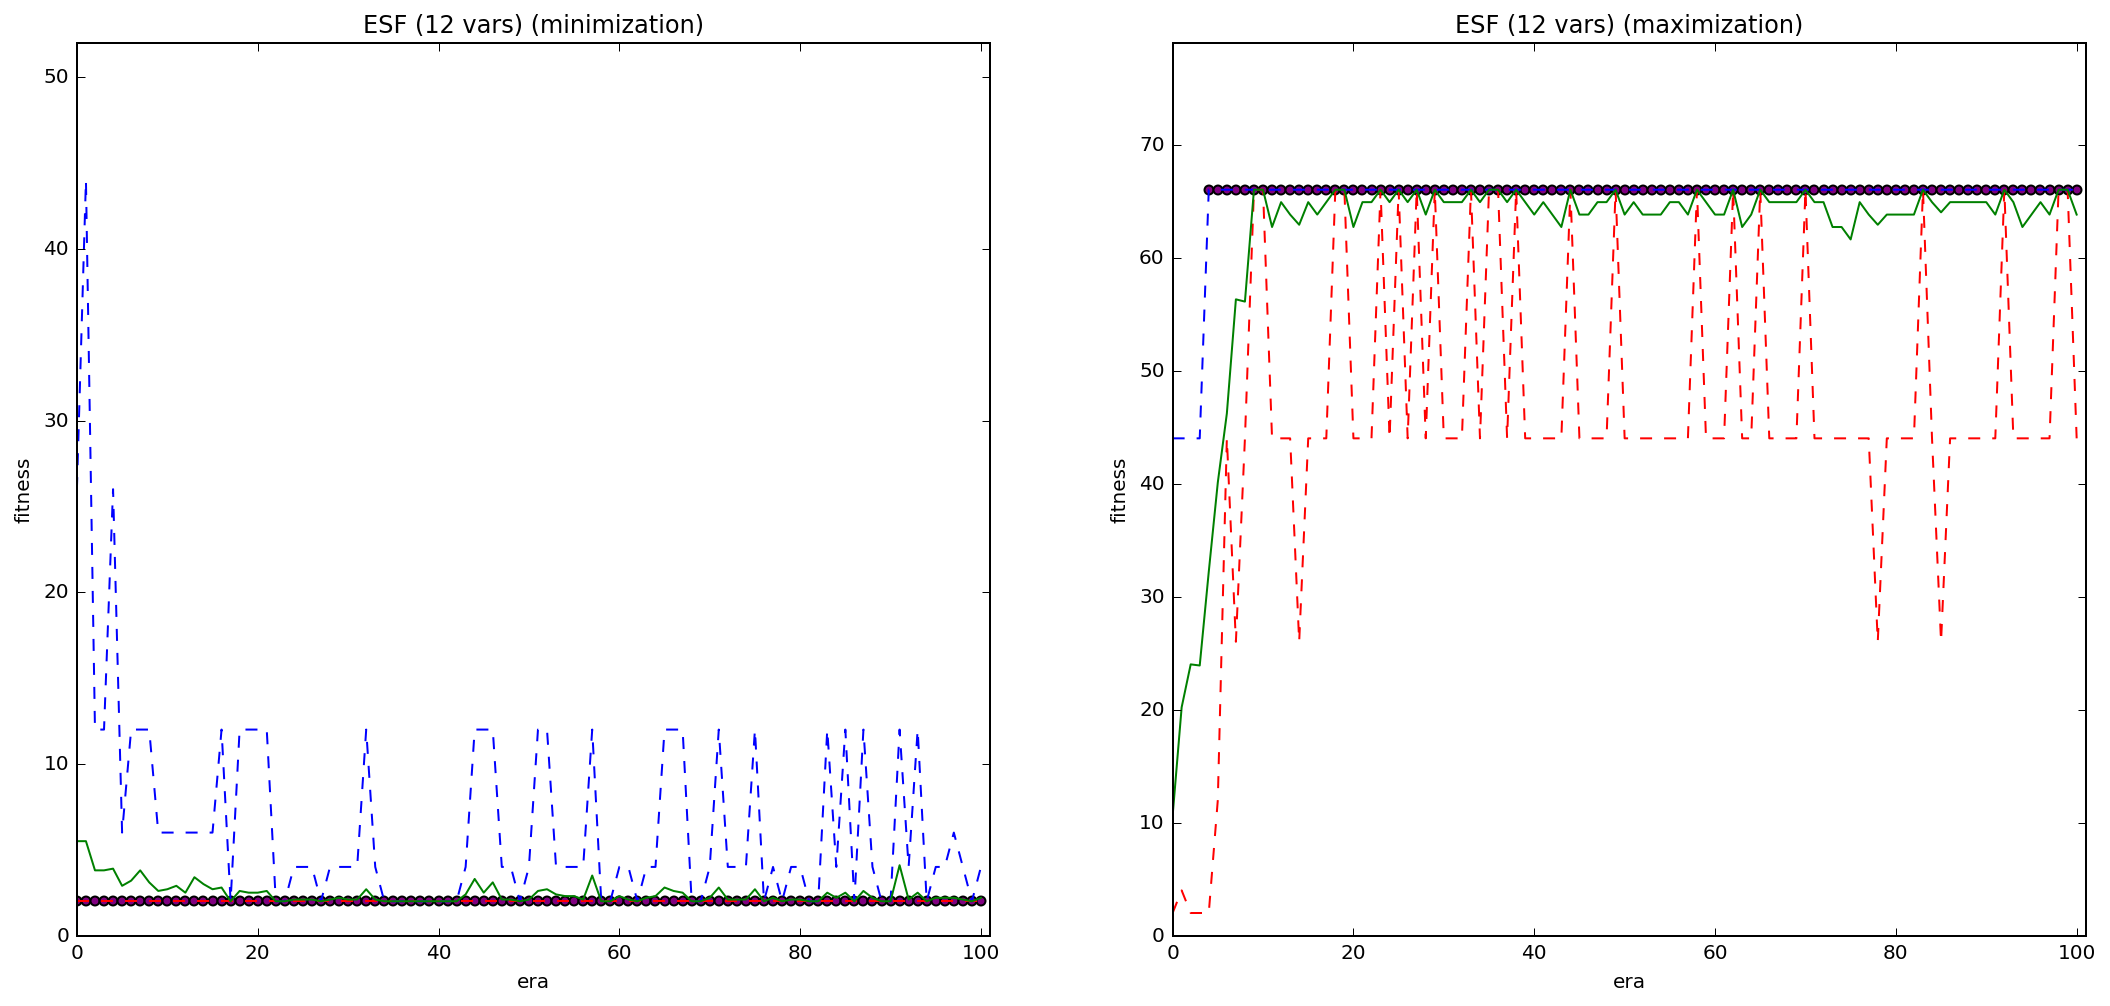

In [16]:
plot_esf_minmax(12)

### NOV = 14

In [17]:
solve_and_print(14)

nov14  =>  min fitness = 1     max fitness = 91  


** NOV = 14, MIN = 1, MAX = 91 **


 minimization 

Global optimum: 00011100001010
Fitness: 1
Decoded: [-1, -1, -1, 1, 1, 1, -1, -1, -1, -1, 1, -1, 1, -1]

 maximization 

Global optimum: 00000000000000
Fitness: 91
Decoded: [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]


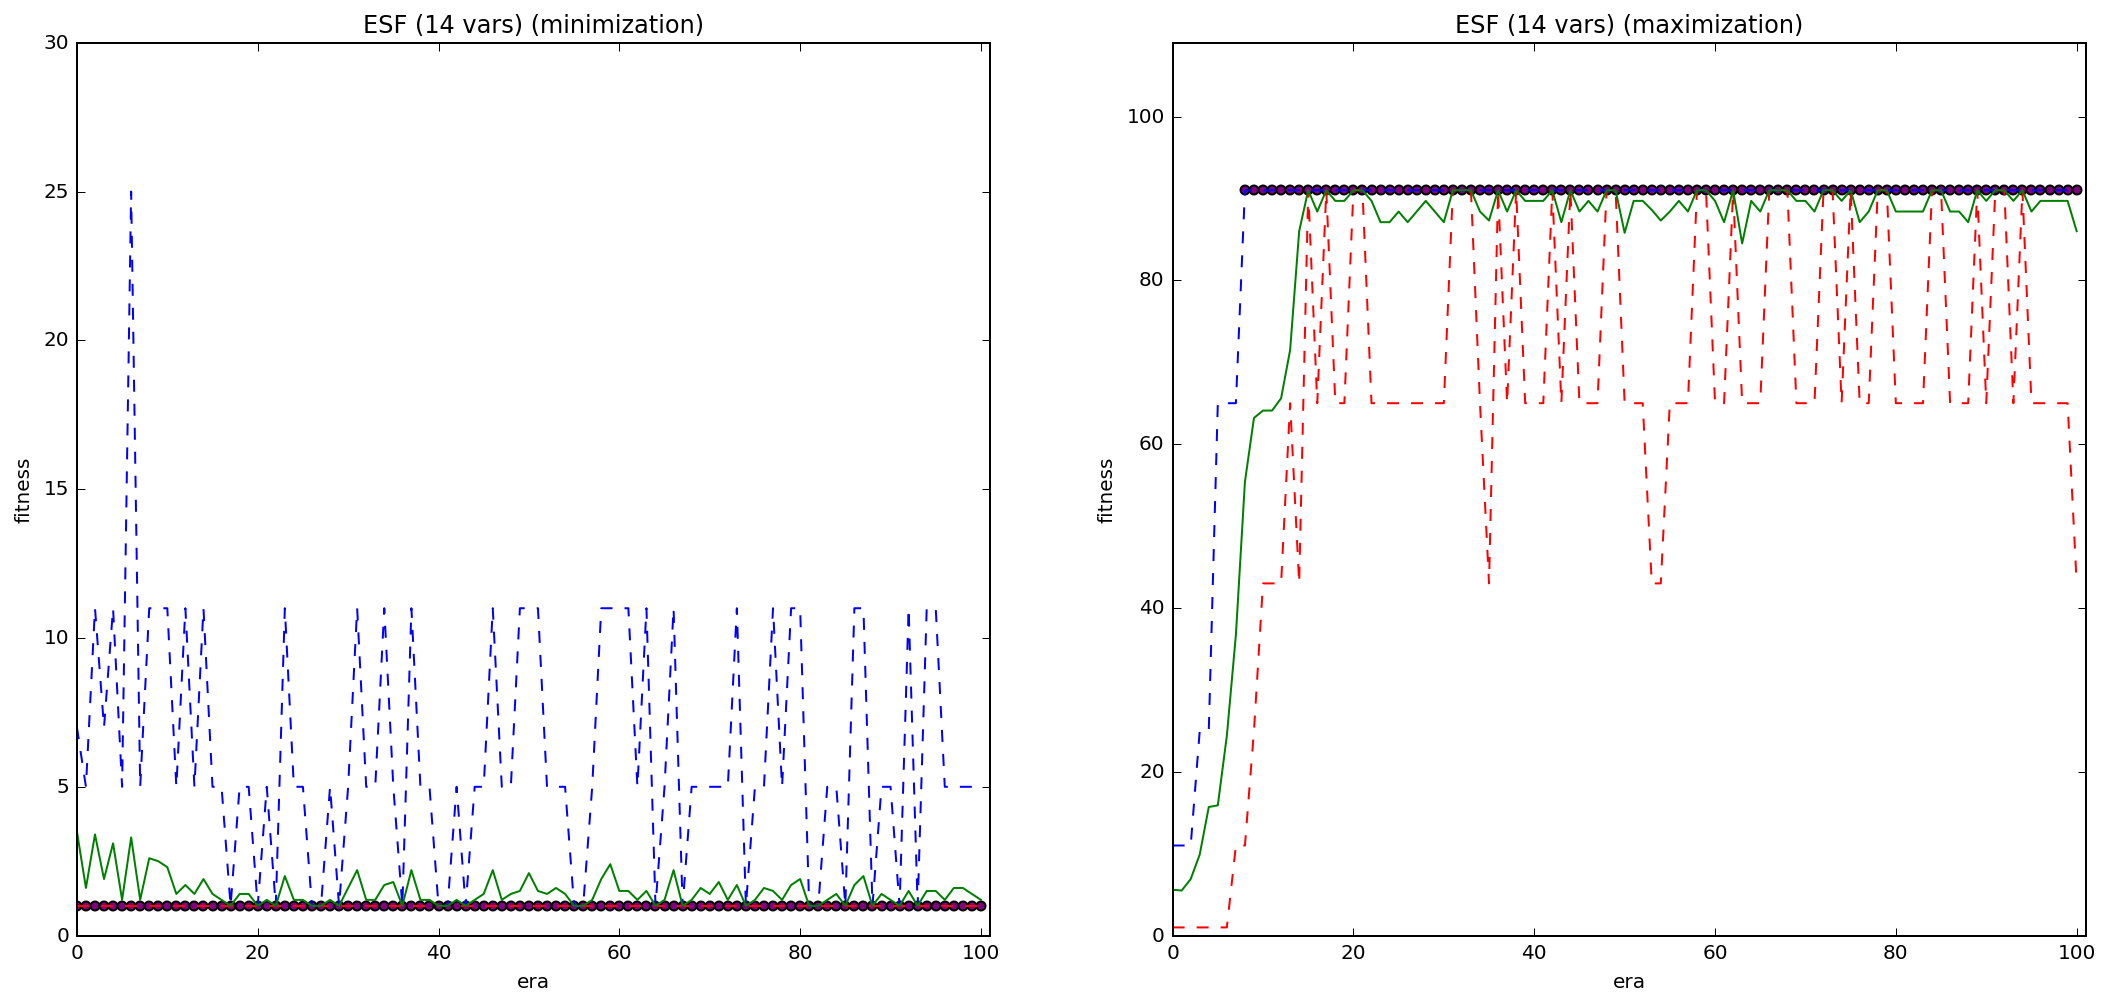

In [18]:
plot_esf_minmax(14)

### NOV = 27

** MIN and MAX not solved with brute force **


 minimization 

Global optimum: 100100101101001100100101000
Fitness: 1
Decoded: [1, -1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, -1, 1, -1, 1, -1, -1, -1]

 maximization 

Global optimum: 000000000000000000000000000
Fitness: 351
Decoded: [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]


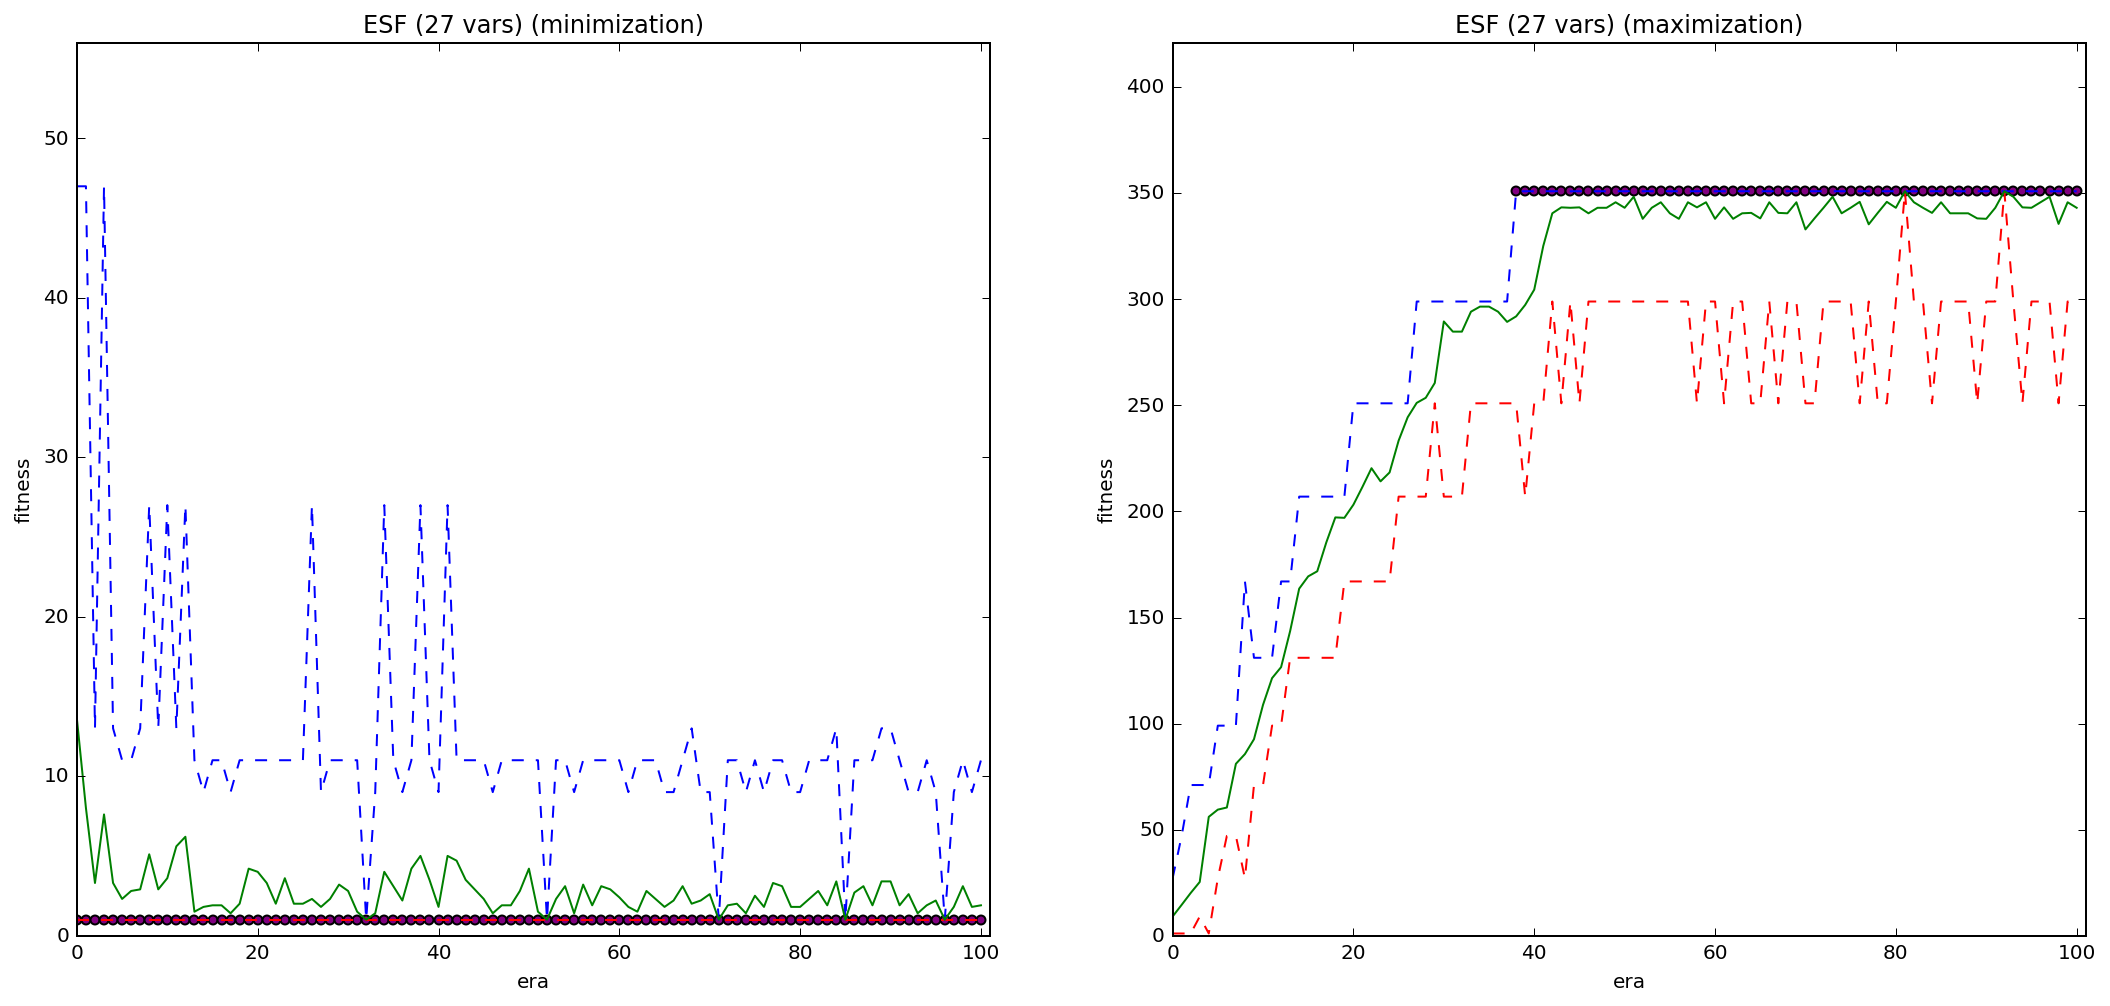

In [19]:
plot_esf_minmax(27)

### NOV = 35


 minimization 

Global optimum: 11010111000001110101011110010011110
Fitness: 5
Decoded: [1, 1, -1, 1, -1, 1, 1, 1, -1, -1, -1, -1, -1, 1, 1, 1, -1, 1, -1, 1, -1, 1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, 1, -1]

 maximization 

Global optimum: 00000000000000000000000000000000000
Fitness: 595
Decoded: [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]


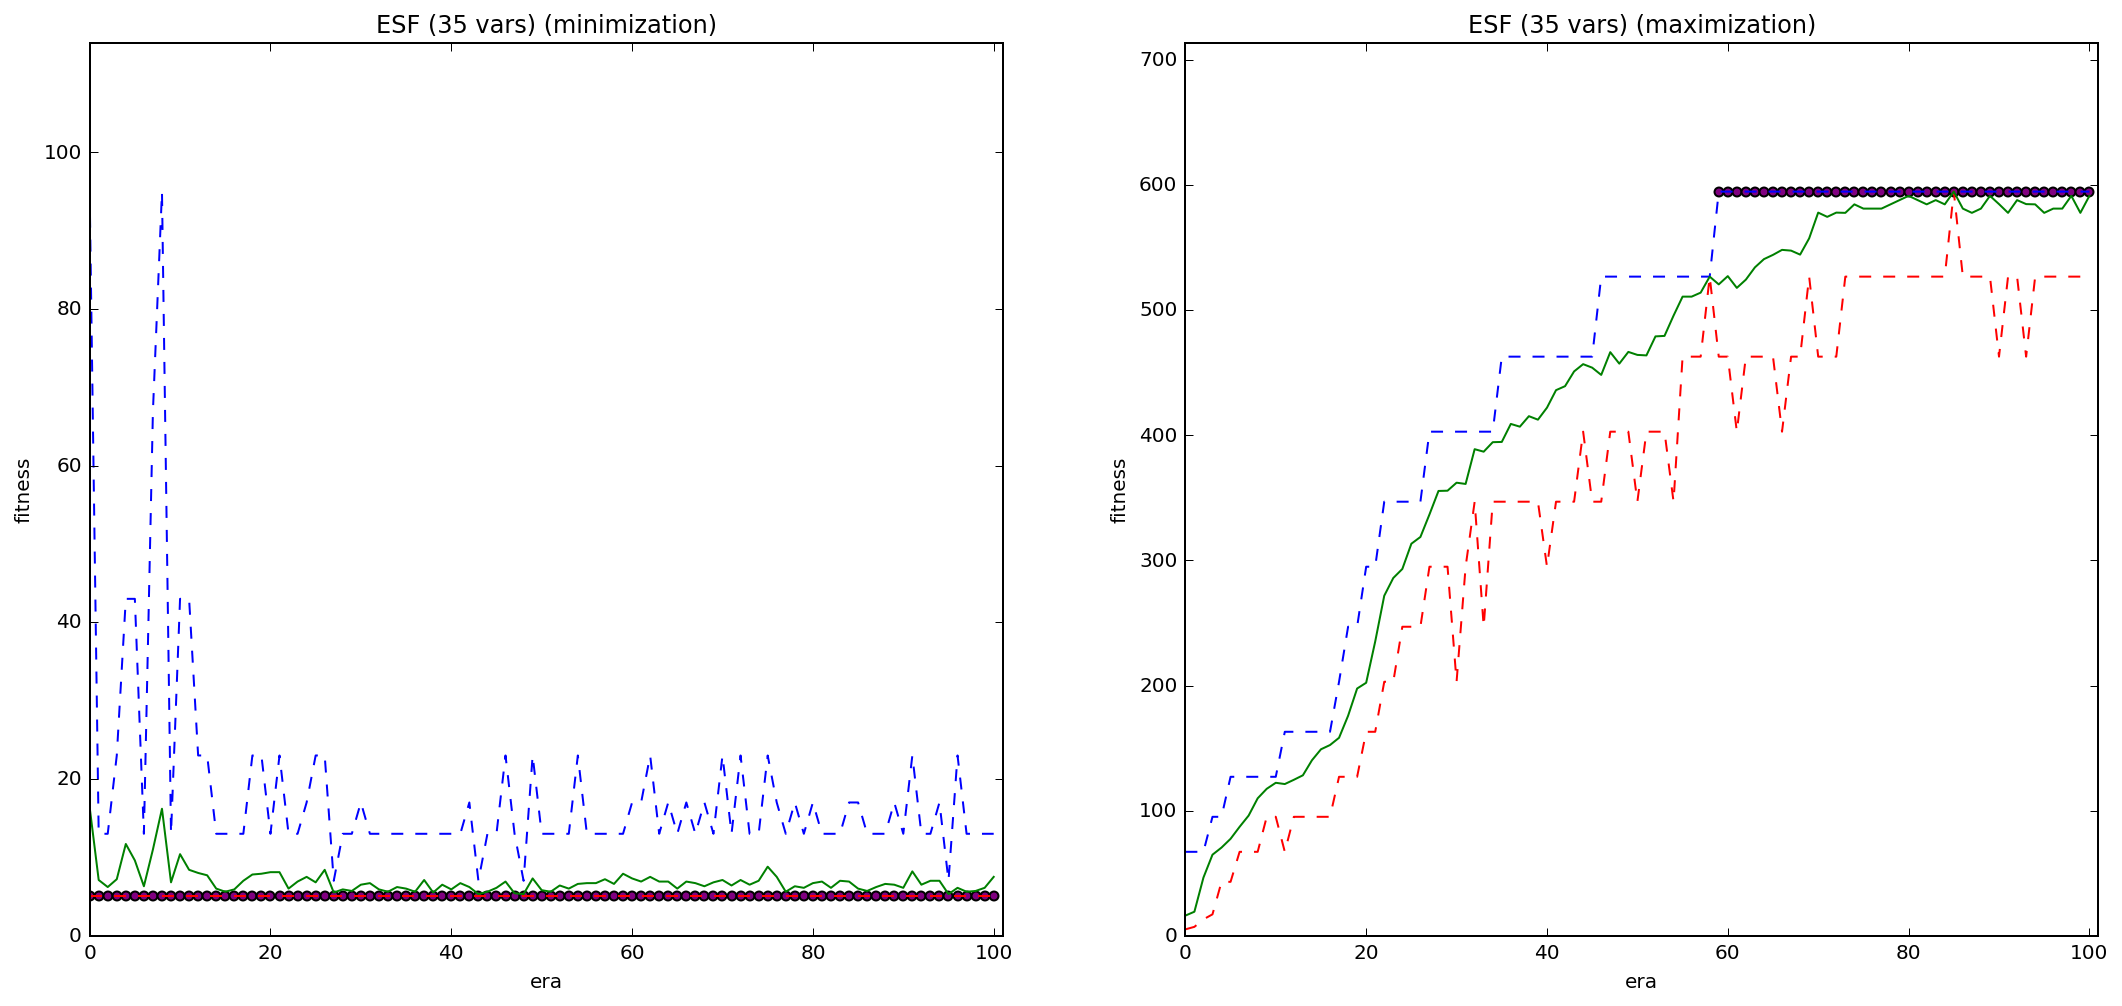

In [20]:
plot_esf_minmax(35)

### NOV = 100

Maximization requires more than 100 eras for a good probability of converging to 4950, which appears to the be maximum value.


 minimization 

Global optimum: 0010110010010110000101100011101100010111110111001111111100110000101010111001111100011000110101111100
Fitness: 0
Decoded: [-1, -1, 1, -1, 1, 1, -1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, -1, -1, 1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, 1, 1, -1, -1, -1, 1, -1, 1, 1, 1, 1, 1, -1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, -1, -1, -1, 1, 1, -1, -1, -1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, -1, -1]

 maximization 

Global optimum: 0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
Fitness: 4950
Decoded: [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1

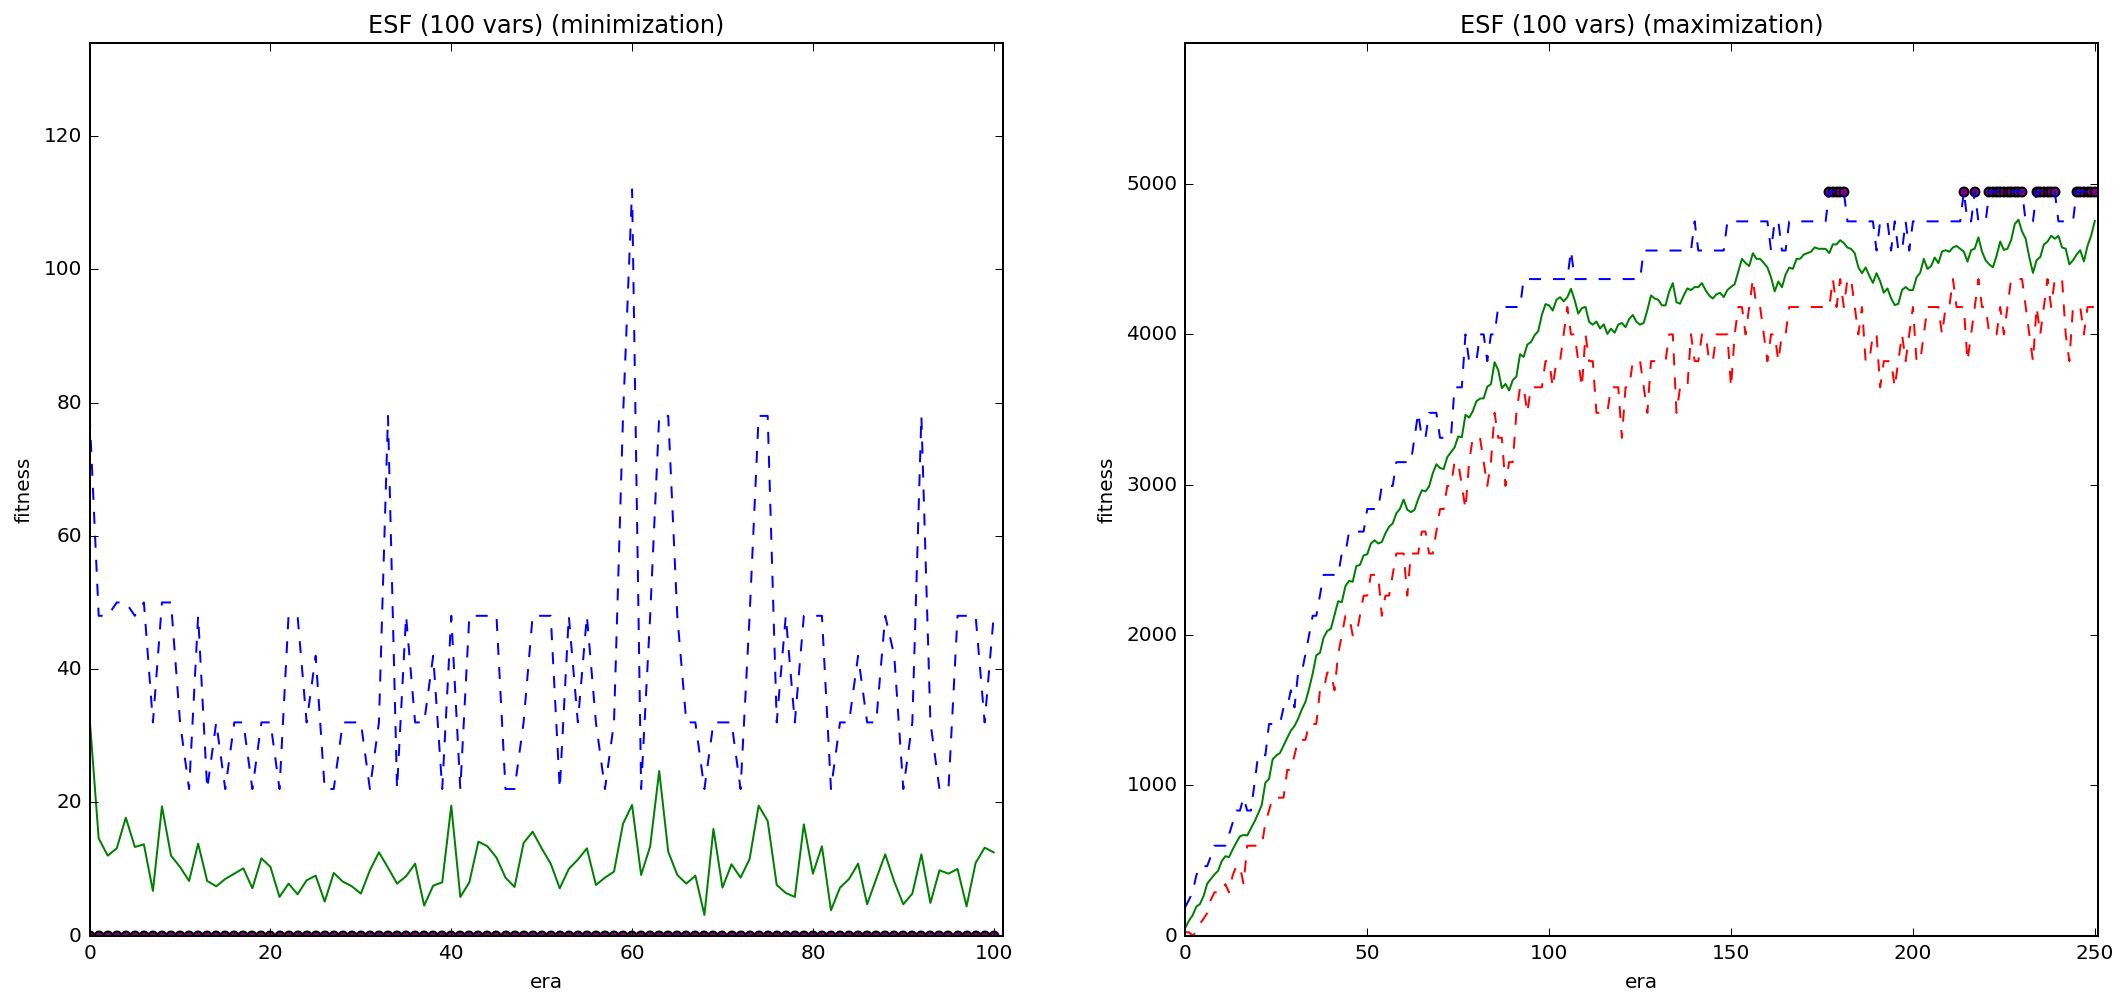

In [21]:
plot_esf_minmax(100, max_ga_opts={'num_eras': 250})